<h1> P5 - CIFAR-10 with CNN </h1>
Levi Verhoef - levi.verhoef@student.hu.nl - 1785902
March 2022

In this pipeline I will try to classify images in the CIFAR-10 dataset with a convoluted neural network. The CIFAR-10 dataset is a dataset of 60000 pictures of 32x32 pixels size with 10 distinct categorical classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck

<h2> Imports </h2>

We start off by importing some useful packages and defining some functions for the future:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as  tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
label_to_string = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Some functions to plot things later:

In [2]:
def plotmodelhistory(history):
    ### sourced from: https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer ###
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

In [3]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    ### sourced from: https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer ###
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

<h2> Data exploration and preparation: </h2>

I start off by importing the dataset and splitting it into a train- and testset:

In [4]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test)=cifar10.load_data()

string_labels = [label_to_string[int(i)] for i in y_train]

print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


This dataset contains matrices of 32x32x3, which represents 32 pixel by 32 pixel images with 3 color values per pixel. The images look like this:

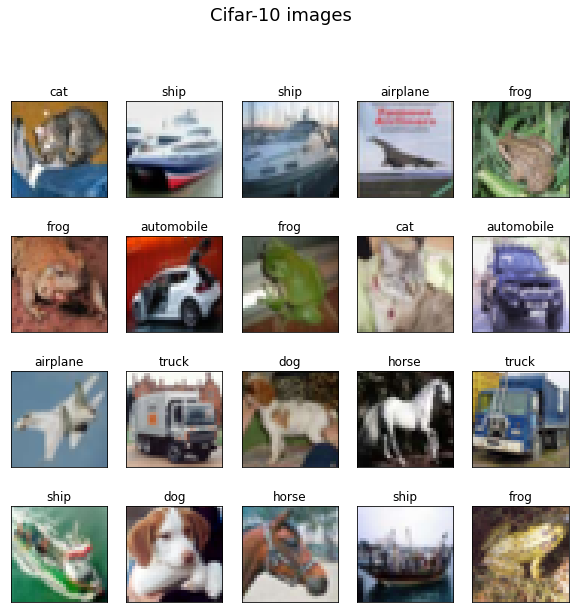

In [5]:
fig = plt.figure(figsize=(10, 12)) 
for i in range(20):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
    plt.imshow(x_test[i])
    fig.suptitle('Cifar-10 images', fontsize=18)
    ax.set_title(label_to_string[int(y_test[i])])

We can see that our x_train has 50.000 images. Lets check if the classes are evenly distributed:

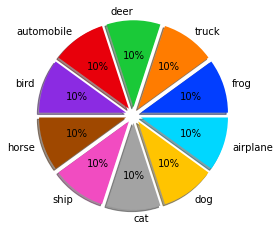

In [6]:
colors = sns.color_palette('bright')[0:10]
y_train_count = Counter([label_to_string[i] for i in y_train.ravel()])

plt.pie(y_train_count.values(), labels = y_train_count.keys(), colors = colors, explode=[0.09]*10, shadow='True', autopct='%.0f%%')
plt.show()

We can see that the classes are evenly distributed.

<h3> Normalizing and one-hot-encoding </h3>

Our data is 60000 images, represented as 60000 matrices of size 32x32x3, where the 32x32 represents the pixels, and the 3 represents their R/G/B values, ranging from 0-255, where 0 means the minimum and 255 means the maximum value for a certain colour.

We can normalize this data by dividing it by 255. This means that every pixel and RGB value will now be between 0 and 1, instead of 0 and 255. 



In [7]:
x_train = x_train.astype(np.float32)   # Verander datatype van integers naar 32-bit floats
x_test = x_test.astype(np.float32) 
x_train /= 255
x_test /= 255

Since our desired output is 10 categorical classes numbered from 0 to 9, it makes sense to one-hot encode our targets. If we don't, we allow the neural network to assume that there is natural ordering in the values which may lead to poor performance.

This means that instead of representing our desired output as a single digit, we represent our output classes as a list, where the index position corresponding to our desired output is marked as one, and the rest marked as zero. Output class 7 would look like this when using one-hot-encoding: [0,0,0,0,0,0,0,1,0,0,0]. 

Let's do that:

In [8]:
from tensorflow.keras.utils import to_categorical

y_train_cat=to_categorical(y_train,10)
y_test_cat=to_categorical(y_test,10)

<h2> Convolutional Keras Layers </h2>

Here we start to try out some keras built-in layers that were designed for image recognition, starting with Conv2D and MaxPooling2D. 

<h3>Conv2D</h3>
Conv2D is a convolutional layer that allows us to create a tensor of outputs by systematically applying filters to small parts of the input. We "scan" over parts of the input and create a feature map of activations. 

<h3>Max Pooling </h3>
Maxpooling 2D downsamples the input, looking at a 2x2 window in this case. It looks at a 2x2 kernel and determines the max value. What this means is we end up with a smaller map, but it will allow our model to learn to detect the objects of interest. 

<h3> The base model </h3>

We'll start off with one convolutional layer with 32 filters with a kernel size of 3x3. This means the convolutional layer will "move" over the input with a 3x3 "window", learning 32 different "features". 

The output size will be the same as the input size, as we have defined padding='same'. As an activation function, we'll use RELU throughout. 

Then, we'll have one convolutional layer with 64 filters, also with a kernel size of 3x3,

and finally, one layer with 128 filters with once again the same 3x3 kernel size.

Once the input has passed through these layers it will become flattened by a Flatten layer and passed into two Dense layers with 1024 units, into finally a 10-output Dense with a softmax activation, which will give us a likelihood of a certain class.

This model has no overfitting measures implemented so will likely score well on the trainset but do comparatively poor on the testset. Lets see!


In [9]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import schedules
from tensorflow.keras import utils
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers

In [10]:
base_model = Sequential()

base_model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
base_model.add(Activation('relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))

base_model.add(Conv2D(64, (3, 3), padding='same'))
base_model.add(Activation('relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))

base_model.add(Conv2D(128, (3, 3), padding='same'))
base_model.add(Activation('relu'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))

base_model.add(Flatten())
base_model.add(Dense(256, activation='relu'))
base_model.add(Dense(10, activation='softmax'))

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         7

In [11]:
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_base = base_model.fit(x_train, y_train_cat,
                              batch_size=128,
                              epochs=50,
                              validation_data=(x_test, y_test_cat),
                              verbose=1) 



Epoch 1/50
391/391 [==============================] - 5s 7ms/step - loss: 1.4771 - accuracy: 0.4658 - val_loss: 1.2728 - val_accuracy: 0.5447
Epoch 2/50
391/391 [==============================] - 2s 6ms/step - loss: 1.0533 - accuracy: 0.6270 - val_loss: 1.0697 - val_accuracy: 0.6173
Epoch 3/50
391/391 [==============================] - 2s 6ms/step - loss: 0.8762 - accuracy: 0.6942 - val_loss: 0.9162 - val_accuracy: 0.6798
Epoch 4/50
391/391 [==============================] - 2s 6ms/step - loss: 0.7623 - accuracy: 0.7361 - val_loss: 0.7894 - val_accuracy: 0.7299
Epoch 5/50
391/391 [==============================] - 2s 6ms/step - loss: 0.6678 - accuracy: 0.7672 - val_loss: 0.8052 - val_accuracy: 0.7316
Epoch 6/50
391/391 [==============================] - 2s 6ms/step - loss: 0.5982 - accuracy: 0.7913 - val_loss: 0.7485 - val_accuracy: 0.7460
Epoch 7/50
391/391 [==============================] - 2s 6ms/step - loss: 0.5255 - accuracy: 0.8174 - val_loss: 0.7287 - val_accuracy: 0.7577
Epoch 

In [28]:
loss, accuracy = base_model.evaluate(x_test, y_test_cat)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 1s 2ms/step - loss: 2.4534 - accuracy: 0.7366
Test loss: 2.4534
Test accuracy: 0.7366


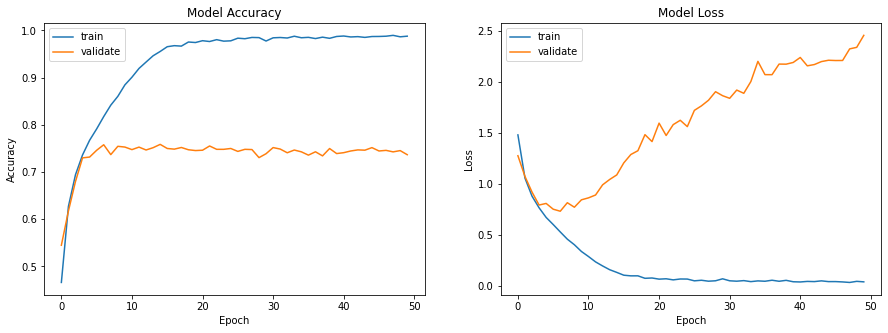

In [12]:
plotmodelhistory(history_base)

At around ~73%, we are doing okay, but we can clearly see that this model is horribly overfitting. Lets try to mitigate that a little bit. We start by adding some dropout and some batchnormalization layers, as learned during the Machine Learning course:

In [13]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(128, (3, 3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.4))
model_2.add(Dense(10, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_2 = model_2.fit(x_train, y_train_cat,
               batch_size=128,
               epochs=50,
               validation_data=(x_test, y_test_cat),
               verbose=1) 

loss, accuracy = model_2.evaluate(x_test, y_test_cat)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/50
391/391 [==============================] - 5s 10ms/step - loss: 1.5644 - accuracy: 0.4544 - val_loss: 2.6166 - val_accuracy: 0.2190
Epoch 2/50
391/391 [==============================] - 3s 9ms/step - loss: 1.1383 - accuracy: 0.5963 - val_loss: 1.1888 - val_accuracy: 0.5632
Epoch 3/50
391/391 [==============================] - 3s 9ms/step - loss: 0.9992 - accuracy: 0.6493 - val_loss: 1.1494 - val_accuracy: 0.5879
Epoch 4/50
391/391 [==============================] - 3s 9ms/step - loss: 0.9158 - accuracy: 0.6791 - val_loss: 1.1135 - val_accuracy: 0.6125
Epoch 5/50
391/391 [==============================] - 3s 9ms/step - loss: 0.8568 - accuracy: 0.6994 - val_loss: 0.9089 - val_accuracy: 0.6740
Epoch 6/50
391/391 [==============================] - 3s 9ms/step - loss: 0.8045 - accuracy: 0.7183 - val_loss: 0.7497 - val_accuracy: 0.7365
Epoch 7/50
391/391 [==============================] - 3s 9ms/step - loss: 0.7725 - accuracy: 0.7291 - val_loss: 0.9827 - val_accuracy: 0.6543
Epoch

In [27]:
loss, accuracy = model_2.evaluate(x_test, y_test_cat)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.7720 - accuracy: 0.7701
Test loss: 0.7720
Test accuracy: 0.7701


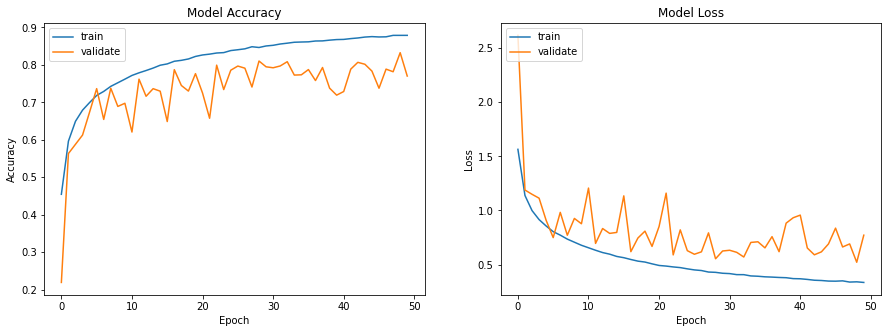

In [15]:
plotmodelhistory(history_2)

These graphs look a lot closer and suggest the model is overfitting less, and also scoring a very nice ~82% accuracy.
However, surely a better score can surely be achieved. Let's try to double up on Conv2D layers:

In [16]:
model_3 = Sequential()

model_3.add(Conv2D(32, (3,3), padding='same', input_shape=x_train.shape[1:]))
model_3.add(BatchNormalization()) 
model_3.add(Activation('relu'))

model_3.add(Conv2D(32, (3,3), padding='same'))
model_3.add(BatchNormalization()) 
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.2)) 
    
model_3.add(Conv2D(64, (3,3), padding='same'))
model_3.add(BatchNormalization()) 
model_3.add(Activation('relu'))

model_3.add(Conv2D(64, (3,3), padding='same'))
model_3.add(BatchNormalization()) 
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.2)) 
    
model_3.add(Conv2D(128, (3,3), padding='same'))
model_3.add(BatchNormalization()) 
model_3.add(Activation('relu'))

model_3.add(Conv2D(128, (3,3), padding='same'))
model_3.add(BatchNormalization()) 
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.2))

model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.4))
model_3.add(Dense(10, activation='softmax'))
 
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)       

In [17]:
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_3 = model_3.fit(x_train, y_train_cat,
               batch_size=128,
               epochs=50,
               validation_data=(x_test, y_test_cat),
               verbose=1) 



Epoch 1/50
391/391 [==============================] - 8s 18ms/step - loss: 1.5651 - accuracy: 0.4542 - val_loss: 2.0970 - val_accuracy: 0.2895
Epoch 2/50
391/391 [==============================] - 7s 17ms/step - loss: 1.0090 - accuracy: 0.6416 - val_loss: 0.9749 - val_accuracy: 0.6563
Epoch 3/50
391/391 [==============================] - 7s 17ms/step - loss: 0.8281 - accuracy: 0.7082 - val_loss: 0.8300 - val_accuracy: 0.7231
Epoch 4/50
391/391 [==============================] - 6s 17ms/step - loss: 0.7296 - accuracy: 0.7440 - val_loss: 0.7238 - val_accuracy: 0.7485
Epoch 5/50
391/391 [==============================] - 7s 17ms/step - loss: 0.6615 - accuracy: 0.7671 - val_loss: 0.7001 - val_accuracy: 0.7599
Epoch 6/50
391/391 [==============================] - 7s 17ms/step - loss: 0.6050 - accuracy: 0.7868 - val_loss: 0.7598 - val_accuracy: 0.7472
Epoch 7/50
391/391 [==============================] - 6s 17ms/step - loss: 0.5639 - accuracy: 0.8029 - val_loss: 0.9262 - val_accuracy: 0.7087

In [26]:
loss, accuracy = model_3.evaluate(x_test, y_test_cat)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.6208 - accuracy: 0.8401
Test loss: 0.6208
Test accuracy: 0.8401


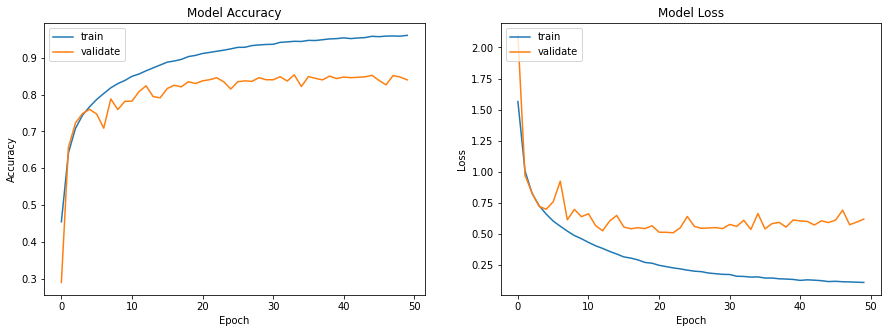

In [18]:
plotmodelhistory(history_3)

Our accuracy is now up to around 85%, which is a very nice score. It seems our model does have the tendency to start overfitting more again.

But why stop there? There's some more features of keras we can play with. Lets try to add L2 regularization next. (I tried L1, but L2 performed better). 

In [19]:
weight_decay = 0.0001

model_4 = Sequential()

model_4.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))

model_4.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.2))

model_4.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))

model_4.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.3))

model_4.add(Conv2D(128, (2, 2), kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))

model_4.add(Conv2D(128, (2, 2), kernel_regularizer=regularizers.l2(weight_decay), padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.4))

model_4.add(Flatten())
model_4.add(Dense(256, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.4))
model_4.add(Dense(10, activation='softmax'))

In [20]:
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_4 = model_4.fit(x_train, y_train_cat,
               batch_size=128,
               epochs=50,
               validation_data=(x_test, y_test_cat),
               verbose=1) 


Epoch 1/50
391/391 [==============================] - 8s 19ms/step - loss: 1.7162 - accuracy: 0.4175 - val_loss: 2.3344 - val_accuracy: 0.2610
Epoch 2/50
391/391 [==============================] - 7s 17ms/step - loss: 1.2012 - accuracy: 0.5823 - val_loss: 1.2041 - val_accuracy: 0.5819
Epoch 3/50
391/391 [==============================] - 7s 17ms/step - loss: 1.0265 - accuracy: 0.6490 - val_loss: 2.0110 - val_accuracy: 0.4002
Epoch 4/50
391/391 [==============================] - 7s 17ms/step - loss: 0.9226 - accuracy: 0.6884 - val_loss: 0.7861 - val_accuracy: 0.7330
Epoch 5/50
391/391 [==============================] - 7s 17ms/step - loss: 0.8472 - accuracy: 0.7154 - val_loss: 0.8262 - val_accuracy: 0.7284
Epoch 6/50
391/391 [==============================] - 7s 17ms/step - loss: 0.7992 - accuracy: 0.7322 - val_loss: 1.0512 - val_accuracy: 0.6513
Epoch 7/50
391/391 [==============================] - 7s 17ms/step - loss: 0.7561 - accuracy: 0.7504 - val_loss: 0.8854 - val_accuracy: 0.7149

In [25]:
loss, accuracy = model_4.evaluate(x_test, y_test_cat)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.5565 - accuracy: 0.8529
Test loss: 0.5565
Test accuracy: 0.8529


In [21]:
pred = model_4.predict(x_test)

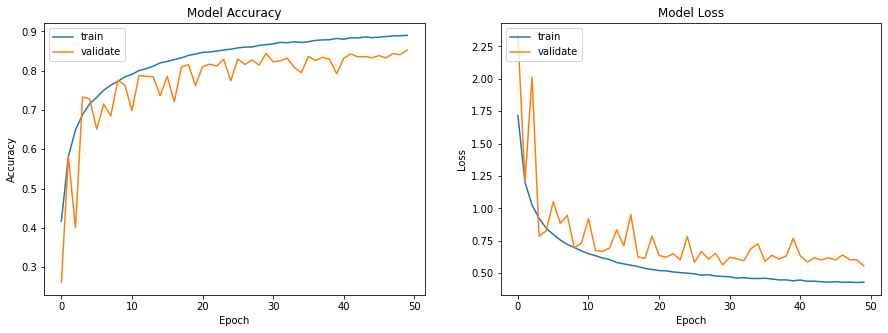

In [22]:
plotmodelhistory(history_4)

Our final model performed quite well, let's visualize the results.

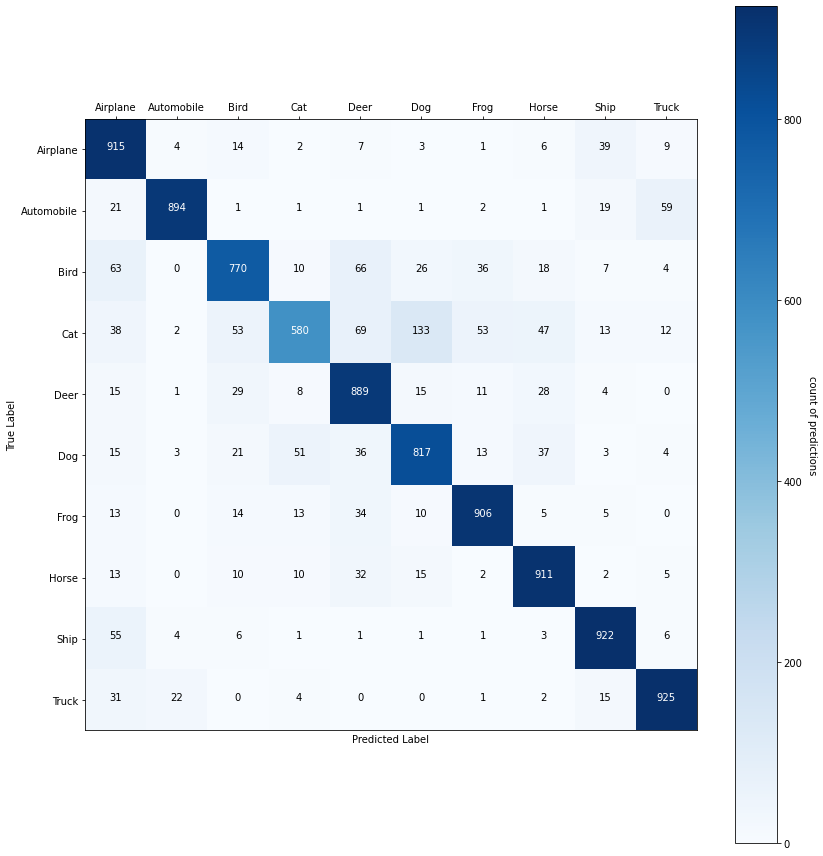

In [23]:
### source: https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer ###
from sklearn.metrics import confusion_matrix
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_cat, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

Here we can see that the model frequently mistakes dogs for cats. Seeing as how they are quite similar, that makes a lot of sense. Automobile and Truck frequently get classified as each other too, but other than that we can see that the model can quite confidently recognize most shapes. Lets, just for fun, take a sample of images and their predicted labels:

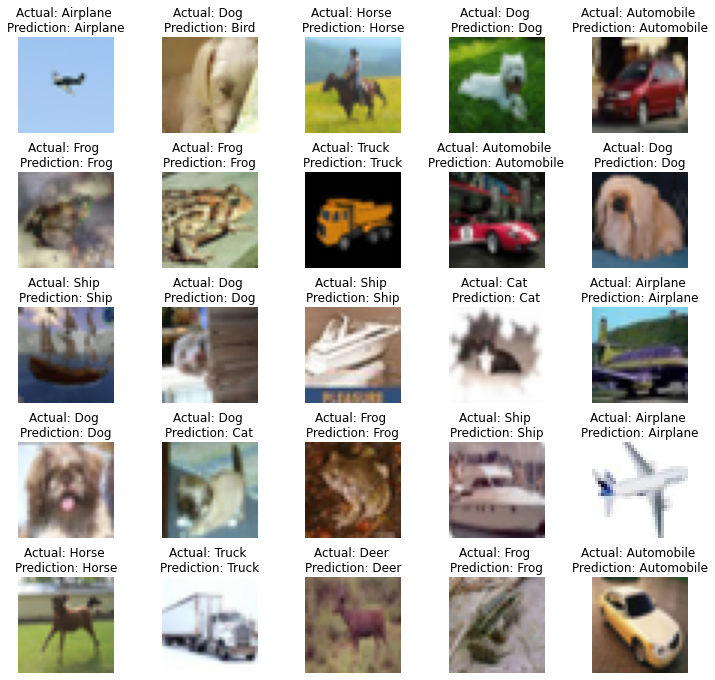

In [24]:
### source: https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer ###
### modifications by me to randomize chosen images ###
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    idx = np.random.randint(0, len(x_test))
    axes[i].imshow(x_test[idx])
    axes[i].set_title("Actual: %s \nPrediction: %s" % (labels[Y_true[idx]], labels[Y_pred_classes[idx]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=0.5)

Very fun to see where the model misclassifies certain images. A lot of them kind of make sense, but some also don't. 

And that's where I'll wrap this up for now. It would be interesting to also test out data augmentation, but that's for another time. We have explored a lot of interesting techniques for CNN models and have learned a lot.